0:	learn: 0.6442913	total: 7.41ms	remaining: 7.41s
200:	learn: 0.1007418	total: 718ms	remaining: 2.85s
400:	learn: 0.0322701	total: 1.58s	remaining: 2.36s
600:	learn: 0.0153415	total: 2.27s	remaining: 1.51s
800:	learn: 0.0090979	total: 2.96s	remaining: 736ms
999:	learn: 0.0073243	total: 3.63s	remaining: 0us
Accuracy: 80.00%


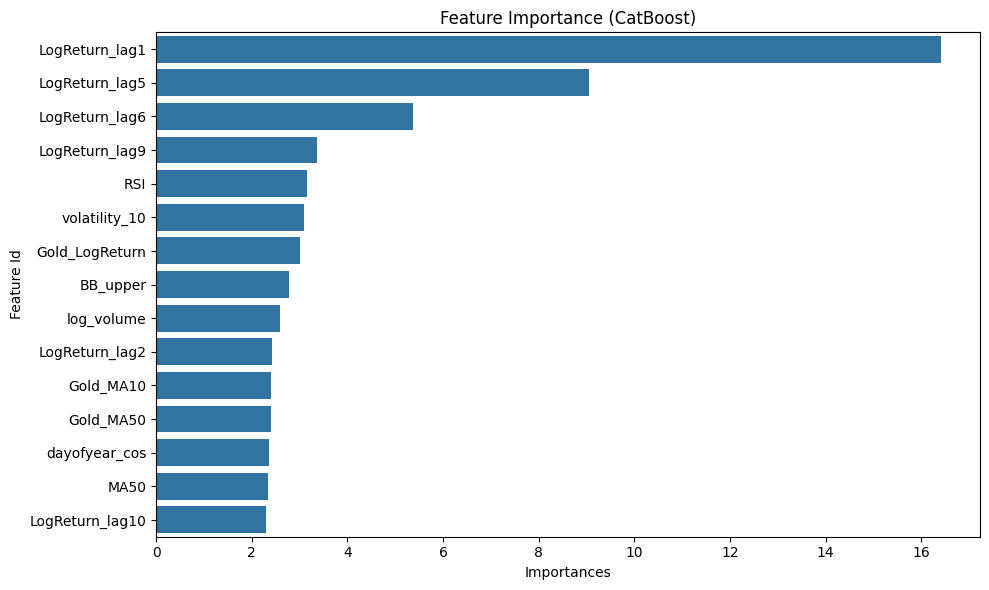

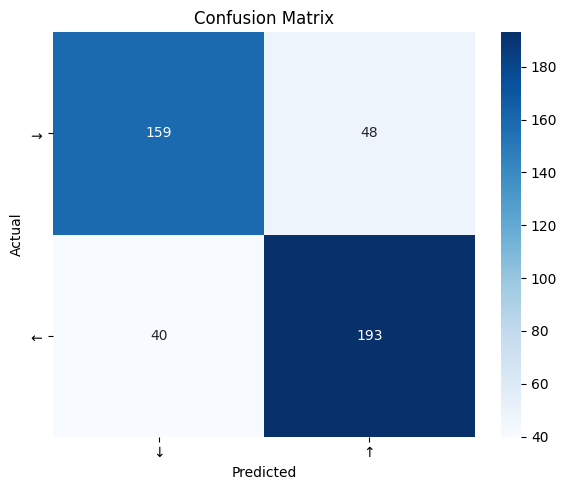

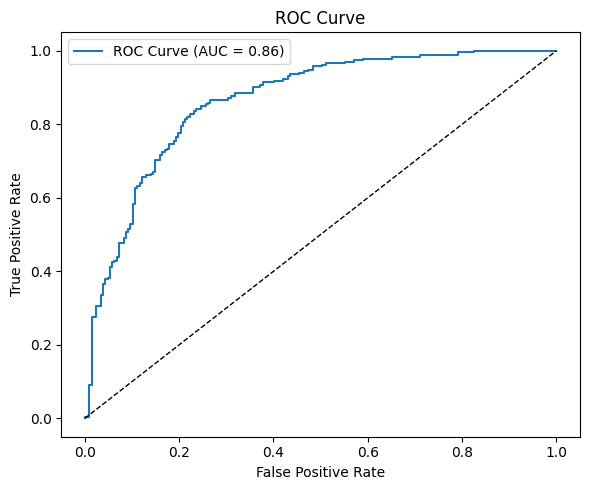

              precision    recall  f1-score   support

           0       0.80      0.77      0.78       207
           1       0.80      0.83      0.81       233

    accuracy                           0.80       440
   macro avg       0.80      0.80      0.80       440
weighted avg       0.80      0.80      0.80       440



In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc

# Wczytanie danych
data = pd.read_csv('transformed_data.csv')
data_class = data.copy()

# Przekształcenie 'LogReturn' do wartości binarnych
data_class['LogReturn'] = (data['LogReturn'] > 0).astype(int)
data_class['date'] = pd.to_datetime(data_class['date'])
data_class = data_class.loc[data_class['date'].dt.year < 2019]

# Przygotowanie X i Y
X = data_class.drop(['LogReturn', 'date'], axis=1)
Y = data_class['LogReturn']

# Podział danych
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Inicjalizacja i trening modelu
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, verbose=200)
model.fit(X_train, y_train)

# Predykcje
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Dokładność
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# === FEATURE IMPORTANCE ===
feature_importance = model.get_feature_importance(prettified=True)
top15 = feature_importance.sort_values(by='Importances', ascending=False).head(15)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importances', y='Feature Id', data=top15.sort_values(by='Importances', ascending=False))
plt.title('Feature Importance (CatBoost)')
plt.tight_layout()
plt.show()

# === CONFUSION MATRIX ===
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['↓', '↑'], yticklabels=['↓', '↑'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# === ROC CURVE + AUC ===
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


In [11]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Wczytanie danych
data = pd.read_csv('data_final.csv')
data_class = data.copy()

# Obliczanie kwartylów
q1 = data['LogReturn'].quantile(0.25)  # 25. percentyl
q2 = data['LogReturn'].quantile(0.50)  # 50. percentyl (mediana)
q3 = data['LogReturn'].quantile(0.75)  # 75. percentyl

# Przekształcanie 'LogReturn' na 4 klasy na podstawie kwartylów
data_class['LogReturn'] = pd.cut(data['LogReturn'], bins=[-float('inf'), q1, q2, q3, float('inf')],
                                  labels=[0, 1, 2, 3])

# Konwersja kolumny 'date' na daty

# Przygotowanie zmiennych X i Y
X = data_class.drop(['LogReturn'], axis=1)
Y = data_class['LogReturn']

# Podział na zestaw treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Inicjalizacja modelu CatBoost
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.1, 
                           depth=6, 
                           verbose=200)

# Trenowanie modelu
model.fit(X_train, y_train)

# Predykcja
y_pred = model.predict(X_test)

# Ocena dokładności
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


0:	learn: 1.3342473	total: 8.09ms	remaining: 8.08s
200:	learn: 0.5222309	total: 1.1s	remaining: 4.37s
400:	learn: 0.3039467	total: 2.18s	remaining: 3.26s
600:	learn: 0.1984878	total: 3.42s	remaining: 2.27s
800:	learn: 0.1359711	total: 4.5s	remaining: 1.12s
999:	learn: 0.1001189	total: 5.62s	remaining: 0us
Accuracy: 57.73%
